In [1]:
from dateutil.relativedelta import relativedelta, MO
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco
import requests
import re
# collect ETF data 
keys = ['SCHD']


headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0"
}


def main(url):
    with requests.Session() as req:
        req.headers.update(headers)
        for key in keys:
            r = req.get(url.format(key))
            print(f"Extracting: {r.url}")
            goal = re.findall(r'etf\\\/(.*?)\\', r.text)
            print(goal)


main("https://www.zacks.com/funds/etf/{}/holding")

ETF=['AMGN', 'KO', 'VZ', 'MRK', 'AVGO', 'CSCO', 'IBM', 'PEP', 'LMT', 'PFE', 'TXN', 'MO', 'HD', 'ADP', 'BLK', 'MMM', 'USB', 'NEM', 'ITW', 'EMR', 'KMB', 'PRU', 'PAYX', 'VLO', 'ALL', 'FAST', 'TROW', 'OKE', 'FITB', 'CMI', 'TSN', 'HIG', 'BBY', 'NTRS', 'MTB', 'KEY', 'HBAN', 'RF', 'CINF', 'GPC', 'AMCR', 'IP', 'PFG', 'OMC', 'K', 'STLD', 'FNF', 'FHN', 'IPG', 'APO', 'WHR', 'HAS', 'CMA', 'SNA', 'ZION', 'WSO', 'OGN', 'BEN', 'WU', 'SNV', 'UNM', 'SON', 'JHG', 'OZK', 'FLO', 'LEG', 'WBS', 'EVR', 'MSM', 'LAZ', 'CATY', 'BOH', 'FHI', 'CVBF', 'NUS', 'IBOC', 'KD', 'BANR', 'MGRC', 'CNS', 'BGS', 'NWBI', 'HNI', 'FCF', 'BANF', 'MCY', 'SYBT', 'SAFT', 'RGR', 'CHCO', 'STBA', 'PFC', 'EIG', 'AGM', 'SWM', 'HFWA', 'SRCE', 'USD', 'NP', 'PETS', 'CASS', 'EBF']


# download data from yfinance
data= yf.download(ETF, period='10y')


Extracting: https://www.zacks.com/funds/etf/SCHD/holding
['AMGN', 'KO', 'VZ', 'MRK', 'AVGO', 'CSCO', 'IBM', 'PEP', 'LMT', 'PFE', 'TXN', 'MO', 'HD', 'ADP', 'BLK', 'MMM', 'USB', 'NEM', 'ITW', 'EMR', 'KMB', 'PRU', 'PAYX', 'VLO', 'ALL', 'FAST', 'TROW', 'OKE', 'FITB', 'CMI', 'TSN', 'HIG', 'BBY', 'NTRS', 'MTB', 'KEY', 'HBAN', 'RF', 'CINF', 'GPC', 'AMCR', 'IP', 'PFG', 'OMC', 'K', 'STLD', 'FNF', 'FHN', 'IPG', 'APO', 'WHR', 'HAS', 'CMA', 'SNA', 'ZION', 'WSO', 'OGN', 'BEN', 'WU', 'SNV', 'UNM', 'SON', 'JHG', 'OZK', 'FLO', 'LEG', 'WBS', 'EVR', 'MSM', 'LAZ', 'CATY', 'BOH', 'FHI', 'CVBF', 'NUS', 'IBOC', 'KD', 'BANR', 'MGRC', 'CNS', 'BGS', 'NWBI', 'HNI', 'FCF', 'BANF', 'MCY', 'SYBT', 'SAFT', 'RGR', 'CHCO', 'STBA', 'PFC', 'EIG', 'AGM', 'SWM', 'HFWA', 'SRCE', 'USD', 'NP', 'PETS', 'CASS', 'EBF']
[*********************100%***********************]  102 of 102 completed


In [2]:
data = data.dropna(how='all', axis=1)
ETF = list(data['Adj Close'].columns)
#create returns and price
price= data['Adj Close']
#price.index=pd.to_datetime(price.index)
returns=price.pct_change()


volume= data.Volume
#create dataframe
score_df=pd.DataFrame(index=ETF)



In [3]:
# slope of 52 day trend line w 20day lag
def trendline(ETF, price):
    # output df
    trend_df=pd.DataFrame(index=ETF)
    # last 20 day lag
    for day in range(1, 21):   
        # regression to get slope
        trend_df[day] = np.polyfit(range(len(price[day- 252:])), price[day- 252 :], 1)[0]
        # output mean of 20 day lag slope trend
        return trend_df.mean(axis=1)                                                   

In [4]:
def voltren(ETF, volume):
        # output df
        volume_df=pd.DataFrame(index=ETF)
        # 51 week volume trend
        for day in range(1, 21):   
            # regression to get volume trend 
            volume_df[day] = np.polyfit(range(len(volume[day- 252:])), volume[day- 252:], 1)[1]
            return volume_df.mean(axis=1)
        

In [5]:
class mom_factors:
    def __init__(self,data, ETF, price, volume, score_df, returns):
        self.ETF=ETF
        self.price=price
        self.volume=volume
        self.score_df=pd.DataFrame(index=self.ETF)
        self.returns=returns
        self.data=data
    def _trendline(self):
        # output df
        self.trend_df=pd.DataFrame(index=ETF)
        # last 20 day lag
        for day in range(1, 21):   
            # regression to get slope
            self.trend_df[day] = np.polyfit(range(len(self.price[day- 252:])), self.price[day- 252 :], 1)[0]
            # output mean of 20 day lag slope trend
            return self.trend_df.mean(axis=1)   
        
    def _voltren(self):
        # output df
        self.volume_df=pd.DataFrame(index=ETF)
        # 51 week volume trend
        for day in range(1, 21):   
            # regression to get volume trend 
            self.volume_df[day] = np.polyfit(range(len(self.volume[day- 252:])), self.volume[day- 252:], 1)[1]
            return self.volume_df.mean(axis=1)
        
    def _momentum_factors(self):
        # slope of 52 day trend line w 20day lag
        self.score_df['trendline']= self._trendline()

        # precent above 260 day low w 20day lag
        self.roll_min = self.price.rolling(252).min()
        self.score_df['above_260']=(
            (self.price[-260:] - self.roll_min)/self.roll_min)[-20:].mean()

        # 4 over 52 price oscilator 
        self.score_df['P_osc']=(
            (self.price.rolling(20).mean() - self.price.rolling(260).mean())/ self.price.rolling(260).std())[-20:].mean()
        # 39 week return
        self.weekly_ret= self.returns.resample('W').agg(lambda x: (x+1).prod() -1)
        self.past39  = self.weekly_ret.rolling(39).mean()[-1:]
        self.score_df['return_39w'] = self.past39.mean()
            
        # volume tren
        self.score_df['vol_trend']= self._voltren()
        
        #output df of factors
        return self.score_df
    
  # step 2 
# 1) z score so we can rank individual assets
# 2) select from the ranking  def _agg_scores(self):
    def _agg_scores(self):
        
        self.agg_df= self._momentum_factors()
        
        self.agg_df=   (self.agg_df -   self.agg_df.mean()) /  self.agg_df.std()
          
        
        return self.agg_df.mean(axis=1)
    
    def _baskets(self):
    
        self.z_scores = self._agg_scores()
    
        return list(self.z_scores.nlargest(10).index), list(self.z_scores.nsmallest(10).index)
   
    def _success(self):
        
        
        self.longbasket, self.shortbasket = MF._baskets()
        self.long_basket=yf.download(self.longbasket, period='10y')[['Adj Close']]
        self.short_basket=yf.download(self.shortbasket, period='10y')[['Adj Close']]
        self.long_ret=self.long_basket.pct_change().resample("M").sum().shift(-1)
        self.short_ret=self.short_basket.pct_change().resample("M").sum().shift(-1)
        self.longret_yr=(self.long_ret+1).rolling(11).apply(np.prod)-1
        self.shortret_yr=(self.short_ret+1).rolling(11).apply(np.prod)-1
        self.tot_ret= pd.DataFrame(self.longret_yr.mean(axis=1) - self.shortret_yr.mean(axis=1)).shift()

        return self.tot_ret
    

In [6]:
MF= mom_factors(data, ETF, price, volume, score_df, returns)
longbasket, shortbasket = MF._baskets()

In [7]:
algo_profits=MF._success()[-61:]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [8]:
SPY= yf.download('^GSPC', period='5y')
SPY= SPY['Adj Close']
SPY_mtl= SPY.pct_change().resample('M').agg(lambda x: (x+1).prod() -1)

[*********************100%***********************]  1 of 1 completed


In [9]:
results = pd.DataFrame(algo_profits) 

results['SPY_500']= SPY_mtl.values
results['excess']= results.iloc[:,0] - results.iloc[:,1]
results['outperformed']= ['Yes' if i> 0 else 'NO' for i in results.excess]
results


0   SPY_500    excess outperformed
Date                                                 
2017-05-31 -0.032859  0.003082 -0.035941           NO
2017-06-30  0.006158  0.004814  0.001344          Yes
2017-07-31  0.023690  0.019349  0.004341          Yes
2017-08-31  0.028139  0.000546  0.027593          Yes
2017-09-30 -0.012546  0.019303 -0.031849           NO
...              ...       ...       ...          ...
2022-01-31  0.245449 -0.052585  0.298034          Yes
2022-02-28  0.390725 -0.031360  0.422086          Yes
2022-03-31  0.517004  0.035773  0.481231          Yes
2022-04-30  0.548901 -0.087957  0.636858          Yes
2022-05-31  0.614903 -0.038282  0.653186          Yes

[61 rows x 4 columns]

In [10]:
results[results.outperformed == "Yes"].shape

(27, 4)

In [11]:
results.shape

(61, 4)

In [12]:
27/61

0.4426229508196721

In [22]:

results.columns =['ME', 'SPY_500', 'EXCESS', 'OUTPERFORMED']
results
  

ME   SPY_500    EXCESS OUTPERFORMED
Date                                                 
2017-05-31 -0.032859  0.003082 -0.035941           NO
2017-06-30  0.006158  0.004814  0.001344          Yes
2017-07-31  0.023690  0.019349  0.004341          Yes
2017-08-31  0.028139  0.000546  0.027593          Yes
2017-09-30 -0.012546  0.019303 -0.031849           NO
...              ...       ...       ...          ...
2022-01-31  0.245449 -0.052585  0.298034          Yes
2022-02-28  0.390725 -0.031360  0.422086          Yes
2022-03-31  0.517004  0.035773  0.481231          Yes
2022-04-30  0.548901 -0.087957  0.636858          Yes
2022-05-31  0.614903 -0.038282  0.653186          Yes

[61 rows x 4 columns]

<AxesSubplot:xlabel='Date'>

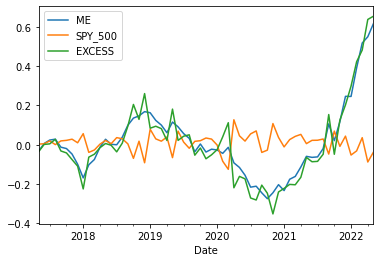

In [24]:
%matplotlib inline
results.plot()